In [343]:
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from typing import Union, Sequence
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
from skimage.color import label2rgb
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import seaborn as sns
from atommic.collections.reconstruction.metrics.reconstruction_metrics import ssim,psnr,haarpsi3d,vsi3d
from atommic.collections.segmentation.metrics.segmentation_metrics import asd, dice_metric, hausdorff_distance_95_metric, f1_per_class_metric,iou_metric
from atommic.collections.segmentation.losses.dice import one_hot
import functools


# Function for plotting MRI scans


def get_scaled_image(
        x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
    """Scales image by intensity percentile (and optionally clips to [0, 1]).

    Args:
      x (torch.Tensor | np.ndarray): The image to process.
      percentile (float): The percentile of magnitude to scale by.
      clip (bool): If True, clip values between [0, 1]

    Returns:
      torch.Tensor | np.ndarray: The scaled image.
    """
    is_numpy = isinstance(x, np.ndarray)
    if is_numpy:
        x = torch.as_tensor(x)

    scale_factor = torch.quantile(x, percentile)
    x = x / scale_factor
    if clip:
        x = torch.clip(x, 0, 1)

    if is_numpy:
        x = x.numpy()

    return x


def plot_images(
        images, processor=None, disable_ticks=True, titles: Sequence[str] = None,
        ylabel: str = None, xlabels: Sequence[str] = None, cmap: str = "gray",
        show_cbar: bool = False, overlay=None, opacity: float = 0.4,
        hsize=5, wsize=5, axs=None, fontsize=20,text=None,show_cbar_overlay: bool=False,ticks_overlay:bool=False,ticks:bool=False,
):
    """Plot multiple images in a single row.

    Add an overlay with the `overlay=` argument.
    Add a colorbar with `show_cbar=True`.
    """

    def get_default_values(x, default=""):
        if x is None:
            return [default] * len(images)
        return x

    titles = get_default_values(titles)
    ylabels = get_default_values(images)
    xlabels = get_default_values(xlabels)

    N = len(images)
    if axs is None:
        fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
    else:
        assert len(axs) >= N
        fig = axs.flatten()[0].get_figure()
    k = 0
    for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
        if processor is not None:
            img = processor(img)
        if type(cmap) == list:
            if cmap[k] =='viridis' or cmap[k] =='jet' :
                im = ax.imshow(img, cmap=cmap[k],vmax=ticks[-1],vmin=ticks[0])
            else:
                im = ax.imshow(img, cmap=cmap[k])
            if type(show_cbar) == list:
                if show_cbar[k]:
                    fig.subplots_adjust(bottom=0.2)
                    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
                    fig.colorbar(im, cax=cbar_ax)
        else:
            im = ax.imshow(img, cmap=cmap)
        k = k + 1
        ax.set_title(title, fontsize=fontsize)
        ax.set_xlabel(xlabel)

    if type(overlay) == list:
        for i, ax in enumerate(axs.flatten()):
            if overlay[i] is not None:
                im = ax.imshow(overlay[i], alpha=opacity,cmap='jet',vmax=ticks_overlay[-1],vmin=ticks_overlay[0])
                if type(show_cbar_overlay) == list:
                    if show_cbar_overlay[i]:
                        cbaxes = inset_axes(ax, width="30%", height="5%")
                        cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal',cmap='jet',ticks=ticks_overlay)
                        cbar.ax.set_xticklabels(labels= ticks_overlay,color='yellow',fontsize=fontsize)

    if type(text) == list:
        for i, ax in enumerate(axs.flatten()):
            if text[i] is not None:
               im = ax.text(.99, .99, text[i], ha='right', va='top', transform=ax.transAxes,fontsize=fontsize,color='yellow')

    if disable_ticks:
        for ax in axs.flatten():
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

    return axs


# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out



def complex_abs(x: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Parameters
    ----------
    x : torch.Tensor
        Complex tensor. The last dimension must be of size 2.

    Returns
    -------
    torch.Tensor
        Absolute value of complex tensor.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import complex_abs
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> complex_abs(data)
    tensor([1.4142, 2.8284, 4.2426])
    """
    if x.shape[-1] != 2:
        if torch.is_complex(x):
            x = torch.view_as_real(x)
        else:
            raise ValueError("Tensor does not have separate complex dim.")
    return (x ** 2).sum(dim=-1)


def check_stacked_complex(x: torch.Tensor) -> torch.Tensor:
    """
    Check if tensor is stacked complex (real & imaginary parts stacked along last dim) and convert it to a combined
    complex tensor.

    Parameters
    ----------
    x : torch.Tensor
        Tensor to check.

    Returns
    -------
    torch.Tensor
        Tensor with stacked complex converted to combined complex.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import check_stacked_complex
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> data = torch.view_as_real(data)
    >>> data.shape
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    """
    return torch.view_as_complex(x) if x.shape[-1] == 2 else x

In [344]:
Patient_id ="MTR_066" #["MTR_052","MTR_066","MTR_120","MTR_196","MTR_227"]
slice =30
echo = 0
intermidiate_form = 'reconstruction' #['loglike','reconstruction']

In [321]:
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-07/predictions/{Patient_id}.h5'
fname= f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_SUM_DEF_2/2024-06-02_18-24-03/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_1 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    inter_pred_mtlrs_1 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/{Patient_id}.h5'
fname= f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_SUM_DEF_2/2024-06-02_18-24-32/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_2 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()


fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/{Patient_id}.h5'
fname= f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_SUM_DEF_2/2024-06-02_18-24-37/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_3 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_3 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_3 = f['zero_filled'][()].squeeze()
inter_pred_mtlrs_1_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_2_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_3_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
mean_logit = np.zeros((80,5,2,256,256),dtype=np.float32)
std_logit = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_std_logit = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_seg_logit = np.zeros((80,5,5,256,256),dtype=np.float32)
for i in range(inter_pred_mtlrs_1.shape[2]):
    inter_pred_mtlrs_1_norm[:,i] = np.abs(inter_pred_mtlrs_1[:,0,i])/np.max(np.abs(inter_pred_mtlrs_1[:,0,i]))
    inter_pred_mtlrs_2_norm[:,i] = np.abs(inter_pred_mtlrs_2[:,0,i])/np.max(np.abs(inter_pred_mtlrs_2[:,0,i]))
    inter_pred_mtlrs_3_norm[:,i] = np.abs(inter_pred_mtlrs_3[:,0,i])/np.max(np.abs(inter_pred_mtlrs_3[:,0,i]))
    mean_logit[:,i]  = np.mean([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i],inter_pred_mtlrs_3_norm[:,i]],axis=0)
    std_logit[:,i]  = np.std([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i],inter_pred_mtlrs_3_norm[:,i]],axis=0)
    inter_std_logit[:,i] = np.mean([inter_pred_mtlrs_1[:,1,i].real,inter_pred_mtlrs_2[:,1,i].real,inter_pred_mtlrs_3[:,1,i].real],axis=0)
    inter_seg_logit[:,i] = one_hot(torch.argmax(torch.softmax(torch.from_numpy(np.mean([prediction_mtlrs_1[:,i],prediction_mtlrs_2[:,i],prediction_mtlrs_3[:,i]],axis=0)),dim=1),dim=1,keepdim=True),num_classes=segmentation_labels_mtlrs_1.shape[1]).float().numpy()
reconstruction_logit_mean = np.mean([reconstruction_mtlrs_1,reconstruction_mtlrs_2,reconstruction_mtlrs_3],axis=0)
reconstruction_logit = np.abs(reconstruction_logit_mean) /np.max(np.abs(reconstruction_logit_mean))


<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [322]:
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-34/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    reconstruction_mtlrs_1 = f['reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    inter_pred_mtlrs_1 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-37/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_2 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()


fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-40/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_3 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_3 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_3 = f['zero_filled'][()].squeeze()
inter_pred_mtlrs_1_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_2_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_3_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
mean_no_mtl = np.zeros((80,5,2,256,256),dtype=np.float32)
std_no_mtl = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_std_no_mtl = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_seg_no_mtl = np.zeros((80,5,5,256,256),dtype=np.float32)
for i in range(inter_pred_mtlrs_1.shape[2]):
    inter_pred_mtlrs_1_norm[:,i] = np.abs(inter_pred_mtlrs_1[:,0,i])/np.max(np.abs(inter_pred_mtlrs_1[:,0,i]))
    inter_pred_mtlrs_2_norm[:,i] = np.abs(inter_pred_mtlrs_2[:,0,i])/np.max(np.abs(inter_pred_mtlrs_2[:,0,i]))
    inter_pred_mtlrs_3_norm[:,i] = np.abs(inter_pred_mtlrs_3[:,0,i])/np.max(np.abs(inter_pred_mtlrs_3[:,0,i]))
    mean_no_mtl[:,i]  = np.mean([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i],inter_pred_mtlrs_3_norm[:,i]],axis=0)
    std_no_mtl[:,i]  = np.std([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i],inter_pred_mtlrs_3_norm[:,i]],axis=0)
    inter_std_no_mtl[:,i] = np.mean([inter_pred_mtlrs_1[:,1,i].real,inter_pred_mtlrs_2[:,1,i].real,inter_pred_mtlrs_3[:,1,i].real],axis=0)
    inter_seg_no_mtl[:,i] = one_hot(torch.argmax(torch.softmax(torch.from_numpy(np.mean([prediction_mtlrs_1[:,i],prediction_mtlrs_2[:,i],prediction_mtlrs_3[:,i]],axis=0)),dim=1),dim=1,keepdim=True),num_classes=segmentation_labels_mtlrs_1.shape[1]).float().numpy()
reconstruction_no_mtl_mean = np.mean([reconstruction_mtlrs_1,reconstruction_mtlrs_2,reconstruction_mtlrs_3],axis=0)
reconstruction_no_mtl = np.abs(reconstruction_no_mtl_mean) /np.max(np.abs(reconstruction_no_mtl_mean))

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [323]:
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-08/predictions/{Patient_id}.h5'
#fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SASG_DEF_2/2024-06-03_14-35-29/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    reconstruction_mtlrs_1 = f['reconstruction'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    inter_pred_mtlrs_1 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-11/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_2 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()


fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-29_11-48-43/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_3 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_3 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_3 = f['zero_filled'][()].squeeze()
inter_pred_mtlrs_1_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_2_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_3_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
mean_sasg = np.zeros((80,5,2,256,256),dtype=np.float32)
std_sasg = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_std_sasg = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_seg_sasg = np.zeros((80,5,5,256,256),dtype=np.float32)
for i in range(inter_pred_mtlrs_1.shape[2]):
    inter_pred_mtlrs_1_norm[:,i] = np.abs(inter_pred_mtlrs_1[:,0,i])/np.max(np.abs(inter_pred_mtlrs_1[:,0,i]))
    inter_pred_mtlrs_2_norm[:,i] = np.abs(inter_pred_mtlrs_2[:,0,i])/np.max(np.abs(inter_pred_mtlrs_2[:,0,i]))
    inter_pred_mtlrs_3_norm[:,i] = np.abs(inter_pred_mtlrs_3[:,0,i])/np.max(np.abs(inter_pred_mtlrs_3[:,0,i]))
    mean_sasg[:,i]  = np.mean([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i],inter_pred_mtlrs_3_norm[:,i]],axis=0)
    std_sasg[:,i]  = np.std([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i],inter_pred_mtlrs_3_norm[:,i]],axis=0)
    inter_std_sasg[:,i] = np.mean([inter_pred_mtlrs_1[:,1,i].real,inter_pred_mtlrs_2[:,1,i].real,inter_pred_mtlrs_3[:,1,i].real],axis=0)
    inter_seg_sasg[:,i] = one_hot(torch.argmax(torch.softmax(torch.from_numpy(np.mean([prediction_mtlrs_1[:,i],prediction_mtlrs_2[:,i],prediction_mtlrs_3[:,i]],axis=0)),dim=1),dim=1,keepdim=True),num_classes=segmentation_labels_mtlrs_1.shape[1]).float().numpy()
reconstruction_sasg_mean = np.mean([reconstruction_mtlrs_1,reconstruction_mtlrs_2,reconstruction_mtlrs_3],axis=0)
reconstruction_sasg = np.abs(reconstruction_sasg_mean) /np.max(np.abs(reconstruction_sasg_mean))

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [324]:
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-28/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    reconstruction_mtlrs_1 = f['reconstruction'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    inter_pred_mtlrs_1 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-31/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_2 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()


fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-31_08-40-15/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_3 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_3 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_3 = f['zero_filled'][()].squeeze()
inter_pred_mtlrs_1_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_2_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_3_norm =np.zeros((80,5,2,256,256))
mean_softmax_tam = np.zeros((80,5,2,256,256),dtype=np.float32)
std_softmax_tam  = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_std_softmax_tam  = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_seg_softmax_tam = np.zeros((80,5,5,256,256),dtype=np.float32)
for i in range(inter_pred_mtlrs_1.shape[2]):
    inter_pred_mtlrs_1_norm[:,i] = np.abs(inter_pred_mtlrs_1[:,0,i])/np.max(np.abs(inter_pred_mtlrs_1[:,0,i]))
    inter_pred_mtlrs_2_norm[:,i] = np.abs(inter_pred_mtlrs_2[:,0,i])/np.max(np.abs(inter_pred_mtlrs_2[:,0,i]))
    inter_pred_mtlrs_3_norm[:,i] = np.abs(inter_pred_mtlrs_3[:,0,i])/np.max(np.abs(inter_pred_mtlrs_3[:,0,i]))
    mean_softmax_tam[:,i]  = np.mean([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i]],axis=0)
    std_softmax_tam[:,i]  = np.std([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i]],axis=0)
    inter_std_softmax_tam[:,i] = np.mean([inter_pred_mtlrs_1[:,1,i].real,inter_pred_mtlrs_2[:,1,i].real,inter_pred_mtlrs_3[:,1,i].real],axis=0)
    inter_seg_softmax_tam[:,i] = one_hot(torch.argmax(torch.softmax(torch.from_numpy(np.mean([prediction_mtlrs_1[:,i],prediction_mtlrs_2[:,i],prediction_mtlrs_3[:,i]],axis=0)),dim=1),dim=1,keepdim=True),num_classes=segmentation_labels_mtlrs_1.shape[1]).float().numpy()
reconstruction_softmax_tam_mean = np.mean([reconstruction_mtlrs_1,reconstruction_mtlrs_2,reconstruction_mtlrs_3],axis=0)
reconstruction_softmax_tam = np.abs(reconstruction_softmax_tam_mean) /np.max(np.abs(reconstruction_softmax_tam_mean))

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [325]:
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-44/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_1 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    inter_pred_mtlrs_1 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-41/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_2 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()


fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-29_11-49-51/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_3 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_3 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_3 = f['zero_filled'][()].squeeze()
inter_pred_mtlrs_1_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_2_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_3_norm =np.zeros((80,5,2,256,256))
mean_softmax_sum = np.zeros((80,5,2,256,256),dtype=np.float32)
std_softmax_sum = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_std_softmax_sum  = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_seg_softmax_sum = np.zeros((80,5,5,256,256),dtype=np.float32)
for i in range(inter_pred_mtlrs_1.shape[2]):
    inter_pred_mtlrs_1_norm[:,i] = np.abs(inter_pred_mtlrs_1[:,0,i])/np.max(np.abs(inter_pred_mtlrs_1[:,0,i]))
    inter_pred_mtlrs_2_norm[:,i] = np.abs(inter_pred_mtlrs_2[:,0,i])/np.max(np.abs(inter_pred_mtlrs_2[:,0,i]))
    inter_pred_mtlrs_3_norm[:,i] = np.abs(inter_pred_mtlrs_3[:,0,i])/np.max(np.abs(inter_pred_mtlrs_3[:,0,i]))
    mean_softmax_sum[:,i]  = np.mean([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i]],axis=0)
    std_softmax_sum[:,i]  = np.std([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i]],axis=0)
    inter_std_softmax_sum[:,i] = np.mean([inter_pred_mtlrs_1[:,1,i].real,inter_pred_mtlrs_2[:,1,i].real,inter_pred_mtlrs_3[:,1,i].real],axis=0)
    inter_seg_softmax_sum[:,i] = one_hot(torch.argmax(torch.softmax(torch.from_numpy(np.mean([prediction_mtlrs_1[:,i],prediction_mtlrs_2[:,i],prediction_mtlrs_3[:,i]],axis=0)),dim=1),dim=1,keepdim=True),num_classes=segmentation_labels_mtlrs_1.shape[1]).float().numpy()
reconstruction_softmax_sum_mean = np.mean([reconstruction_mtlrs_1,reconstruction_mtlrs_2,reconstruction_mtlrs_3],axis=0)
reconstruction_softmax_sum = np.abs(reconstruction_softmax_sum_mean) /np.max(np.abs(reconstruction_softmax_sum_mean))

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [326]:
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-02/predictions/{Patient_id}.h5'
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_DEF_2/2024-06-02_21-02-20/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_1 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    inter_pred_mtlrs_1 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-05/predictions/{Patient_id}.h5'
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_DEF_2/2024-06-02_21-02-23/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_2 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()


fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-08/predictions/{Patient_id}.h5'
fname = f'/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_DEF_2/2024-06-02_21-02-30/predictions/{Patient_id}.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    reconstruction_mtlrs_3 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_3 = f['segmentation'][()].squeeze()
    inter_pred_mtlrs_3 = f['intermediate_'+intermidiate_form][()].squeeze()
    zero_filled_mtlrs_3 = f['zero_filled'][()].squeeze()
inter_pred_mtlrs_1_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_2_norm =np.zeros((80,5,2,256,256),dtype=np.float32)
inter_pred_mtlrs_3_norm =np.zeros((80,5,2,256,256))
mean_logit_tam = np.zeros((80,5,2,256,256),dtype=np.float32)
std_logit_tam  = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_std_logit_tam  = np.zeros((80,5,2,256,256),dtype=np.float32)
inter_seg_logit_tam = np.zeros((80,5,5,256,256),dtype=np.float32)
for i in range(inter_pred_mtlrs_1.shape[2]):
    inter_pred_mtlrs_1_norm[:,i] = np.abs(inter_pred_mtlrs_1[:,0,i])/np.max(np.abs(inter_pred_mtlrs_1[:,0,i]))
    inter_pred_mtlrs_2_norm[:,i] = np.abs(inter_pred_mtlrs_2[:,0,i])/np.max(np.abs(inter_pred_mtlrs_2[:,0,i]))
    inter_pred_mtlrs_3_norm[:,i] = np.abs(inter_pred_mtlrs_3[:,0,i])/np.max(np.abs(inter_pred_mtlrs_3[:,0,i]))
    mean_logit_tam[:,i]  = np.mean([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i]],axis=0)
    std_logit_tam[:,i]  = np.std([inter_pred_mtlrs_1_norm[:,i],inter_pred_mtlrs_2_norm[:,i]],axis=0)
    inter_std_logit_tam[:,i] = np.mean([inter_pred_mtlrs_1[:,1,i].real,inter_pred_mtlrs_2[:,1,i].real,inter_pred_mtlrs_3[:,1,i].real],axis=0)
    inter_seg_logit_tam[:,i] = one_hot(torch.argmax(torch.softmax(torch.from_numpy(np.mean([prediction_mtlrs_1[:,i],prediction_mtlrs_2[:,i],prediction_mtlrs_3[:,i]],axis=0)),dim=1),dim=1,keepdim=True),num_classes=segmentation_labels_mtlrs_1.shape[1]).float().numpy()
reconstruction_logit_tam_mean = np.mean([reconstruction_mtlrs_1,reconstruction_mtlrs_2,reconstruction_mtlrs_3],axis=0)
reconstruction_logit_tam = np.abs(reconstruction_logit_tam_mean) /np.max(np.abs(reconstruction_logit_tam_mean))

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [327]:

print(mean_logit.dtype)
zero_filled_mtlrs_1 = np.abs(zero_filled_mtlrs_1)/np.max(np.abs(zero_filled_mtlrs_1))
target_mtlrs_1 = np.abs(target_mtlrs_1)/np.max(np.abs(target_mtlrs_1))



float32


In [328]:
hsize = 2.5
ticks_overlay = [0.0,0.02,0.04]
fontsize = 10
wsize = hsize / target_mtlrs_1.shape[2] * target_mtlrs_1.shape[3]


max_value = max(np.max(reconstruction_no_mtl[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
fig, axs = plt.subplots(6, 8, figsize=(8 * wsize, 6 * hsize))
plot_images([zero_filled_mtlrs_1[slice,echo],mean_no_mtl[slice,0,echo],mean_no_mtl[slice,1,echo],mean_no_mtl[slice,2,echo],mean_no_mtl[slice,3,echo],mean_no_mtl[slice,4,echo],reconstruction_no_mtl[slice,echo],target_mtlrs_1[slice,echo]],titles=["Zero Filled",intermidiate_form +" C1",intermidiate_form + " C2",intermidiate_form +" C3",intermidiate_form +" C4",intermidiate_form +" C5","Final mean prediction","Target"],axs=axs[0],overlay=[None,std_no_mtl[slice,0,echo],std_no_mtl[slice,1,echo],std_no_mtl[slice,2,echo],std_no_mtl[slice,3,echo],std_no_mtl[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id} \n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[0,0].set_ylabel("NO MTL", fontsize=fontsize)
max_value = max(np.max(reconstruction_logit[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_logit[slice,0,echo],mean_logit[slice,1,echo],mean_logit[slice,2,echo],mean_logit[slice,3,echo],mean_logit[slice,4,echo],reconstruction_logit[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[1],overlay=[None,std_logit[slice,0,echo],std_logit[slice,1,echo],std_logit[slice,2,echo],std_logit[slice,3,echo],std_logit[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[1,0].set_ylabel("SUM LOGIT", fontsize=fontsize)
max_value = max(np.max(reconstruction_softmax_sum[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_softmax_sum[slice,0,echo],mean_softmax_sum[slice,1,echo],mean_softmax_sum[slice,2,echo],mean_softmax_sum[slice,3,echo],mean_softmax_sum[slice,4,echo],reconstruction_softmax_sum[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[2],overlay=[None,std_softmax_sum[slice,0,echo],std_softmax_sum[slice,1,echo],std_softmax_sum[slice,2,echo],std_softmax_sum[slice,3,echo],std_softmax_sum[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[2,0].set_ylabel("SUM SOFTMAX", fontsize=fontsize)
max_value = max(np.max(reconstruction_sasg[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_sasg[slice,0,echo],mean_sasg[slice,1,echo],mean_sasg[slice,2,echo],mean_sasg[slice,3,echo],mean_sasg[slice,4,echo],reconstruction_sasg[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[3],overlay=[None,std_sasg[slice,0,echo],std_sasg[slice,1,echo],std_sasg[slice,2,echo],std_sasg[slice,3,echo],std_sasg[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}'],ticks_overlay=ticks_overlay)
axs[3,0].set_ylabel("SASG", fontsize=fontsize)
max_value = max(np.max(reconstruction_logit_tam[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_logit_tam[slice,0,echo],mean_logit_tam[slice,1,echo],mean_logit_tam[slice,2,echo],mean_logit_tam[slice,3,echo],mean_logit_tam[slice,4,echo],reconstruction_logit_tam[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[4],overlay=[None,std_logit_tam[slice,0,echo],std_logit_tam[slice,1,echo],std_logit_tam[slice,2,echo],std_logit_tam[slice,3,echo],std_logit_tam[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[4,0].set_ylabel("LOGIT TAM", fontsize=fontsize)
max_value = max(np.max(reconstruction_softmax_tam[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_softmax_tam[slice,0,echo],mean_softmax_tam[slice,1,echo],mean_softmax_tam[slice,2,echo],mean_softmax_tam[slice,3,echo],mean_softmax_tam[slice,4,echo],reconstruction_softmax_tam[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[5],overlay=[None,std_softmax_tam[slice,0,echo],std_softmax_tam[slice,1,echo],std_softmax_tam[slice,2,echo],std_softmax_tam[slice,3,echo],std_softmax_tam[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[5,0].set_ylabel("SOFTMAX TAM", fontsize=fontsize)
plt.tight_layout(pad=0)
plt.savefig("/scratch/tmpaquaij/Figures/IP/Intermediate_"+intermidiate_form+f"_DeepEnsemble_UQ_{Patient_id}_Echo:{str(echo)}_slice:{str(slice)}.png")
plt.close()

[atommic W 2024-06-05 11:31:39 atommic_logging:336] /scratch/tmpaquaij/Atommic/ATOMMIC_private/atommic/collections/reconstruction/losses/vsi.py:136: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
      warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '
    
[atommic W 2024-06-05 11:31:39 atommic_logging:336] /scratch/tmpaquaij/Atommic/ATOMMIC_private/atommic/collections/reconstruction/losses/vsi.py:136: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
      warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '
    
[atommic W 2024-06-05 11:31:39 atommic_logging:336] /scratch/tmpaquaij/Atommic/ATOMMIC_private/atommic/collections/reconstruction/losses/vsi.py:136: UserWarning: The original VSI supports only RGB

In [329]:
ticks_overlay = [0.0,0.02,0.04]
max_value = max(np.max(reconstruction_no_mtl[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_no_mtl[slice,echo],maxval=max_value)
fig, axs = plt.subplots(6, 8, figsize=(8 * wsize, 6 * hsize))
plot_images([zero_filled_mtlrs_1[slice,echo],mean_no_mtl[slice,0,echo],mean_no_mtl[slice,1,echo],mean_no_mtl[slice,2,echo],mean_no_mtl[slice,3,echo],mean_no_mtl[slice,4,echo],reconstruction_no_mtl[slice,echo],target_mtlrs_1[slice,echo]],titles=["Zero Filled",intermidiate_form +" C1",intermidiate_form + " C2",intermidiate_form +" C3",intermidiate_form +" C4",intermidiate_form +" C5","Final mean prediction","Target"],axs=axs[0],overlay=[None,inter_std_no_mtl[slice,0,echo],inter_std_no_mtl[slice,1,echo],inter_std_no_mtl[slice,2,echo],inter_std_no_mtl[slice,3,echo],inter_std_no_mtl[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}'],ticks_overlay=ticks_overlay)
axs[0,0].set_ylabel("NO MTL", fontsize=fontsize)
max_value = max(np.max(reconstruction_logit[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_logit[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_logit[slice,0,echo],mean_logit[slice,1,echo],mean_logit[slice,2,echo],mean_logit[slice,3,echo],mean_logit[slice,4,echo],reconstruction_logit[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[1],overlay=[None,inter_std_logit[slice,0,echo],inter_std_logit[slice,1,echo],inter_std_logit[slice,2,echo],inter_std_logit[slice,3,echo],inter_std_logit[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[1,0].set_ylabel("SUM LOGIT", fontsize=fontsize)
max_value = max(np.max(reconstruction_softmax_sum[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_sum[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_softmax_sum[slice,0,echo],mean_softmax_sum[slice,1,echo],mean_softmax_sum[slice,2,echo],mean_softmax_sum[slice,3,echo],mean_softmax_sum[slice,4,echo],reconstruction_softmax_sum[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[2],overlay=[None,inter_std_softmax_sum[slice,0,echo],inter_std_softmax_sum[slice,1,echo],inter_std_softmax_sum[slice,2,echo],inter_std_softmax_sum[slice,3,echo],inter_std_softmax_sum[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[2,0].set_ylabel("SUM SOFTMAX", fontsize=fontsize)
max_value = max(np.max(reconstruction_sasg[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_sasg[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_sasg[slice,0,echo],mean_sasg[slice,1,echo],mean_sasg[slice,2,echo],mean_sasg[slice,3,echo],mean_sasg[slice,4,echo],reconstruction_sasg[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[3],overlay=[None,inter_std_sasg[slice,0,echo],inter_std_sasg[slice,1,echo],inter_std_sasg[slice,2,echo],inter_std_sasg[slice,3,echo],inter_std_sasg[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[3,0].set_ylabel("SASG", fontsize=fontsize)
max_value = max(np.max(reconstruction_logit_tam[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_logit_tam[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_logit_tam[slice,0,echo],mean_logit_tam[slice,1,echo],mean_logit_tam[slice,2,echo],mean_logit_tam[slice,3,echo],mean_logit_tam[slice,4,echo],reconstruction_logit_tam[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[4],overlay=[None,inter_std_logit_tam[slice,0,echo],inter_std_logit_tam[slice,1,echo],inter_std_logit_tam[slice,2,echo],inter_std_logit_tam[slice,3,echo],inter_std_logit_tam[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}'],ticks_overlay=ticks_overlay)
axs[4,0].set_ylabel("LOGIT TAM", fontsize=fontsize)
max_value = max(np.max(reconstruction_softmax_tam[slice,echo]),np.max(target_mtlrs_1[slice,echo]))
ssim_score =ssim(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
psnr_score =psnr(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
haarpsi_score =haarpsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
vsi_score =vsi3d(target_mtlrs_1[slice,echo],reconstruction_softmax_tam[slice,echo],maxval=max_value)
plot_images([zero_filled_mtlrs_1[slice,echo],mean_softmax_tam[slice,0,echo],mean_softmax_tam[slice,1,echo],mean_softmax_tam[slice,2,echo],mean_softmax_tam[slice,3,echo],mean_softmax_tam[slice,4,echo],reconstruction_softmax_tam[slice,echo],target_mtlrs_1[slice,echo]],axs=axs[5],overlay=[None,inter_std_softmax_tam[slice,0,echo],inter_std_softmax_tam[slice,1,echo],inter_std_softmax_tam[slice,2,echo],inter_std_softmax_tam[slice,3,echo],inter_std_softmax_tam[slice,4,echo],None,None],show_cbar_overlay=[False,True,True,True,True,True,False,False],fontsize =fontsize,text=[None,None,None,None,None,None,f'SSIM: {round(ssim_score,3)} \n PSNR: {round(psnr_score,3)} \n HaarPSI: {round(haarpsi_score,3)} \n VSI: {round(vsi_score,3)}',f'Patient: {Patient_id}\n Slice: {slice}'],ticks_overlay=ticks_overlay)
axs[5,0].set_ylabel("SOFTMAX TAM", fontsize=fontsize)
plt.tight_layout(pad=0)
plt.savefig("/scratch/tmpaquaij/Figures/IP/Intermediate_"+intermidiate_form+f"_timestep_UQ_{Patient_id}_Echo:{str(echo)}_slice:{str(slice)}.png")
plt.close()

[atommic W 2024-06-05 11:31:45 atommic_logging:336] /scratch/tmpaquaij/Atommic/ATOMMIC_private/atommic/collections/reconstruction/losses/vsi.py:136: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
      warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '
    
[atommic W 2024-06-05 11:31:46 atommic_logging:336] /scratch/tmpaquaij/Atommic/ATOMMIC_private/atommic/collections/reconstruction/losses/vsi.py:136: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
      warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '
    
[atommic W 2024-06-05 11:31:47 atommic_logging:336] /scratch/tmpaquaij/Atommic/ATOMMIC_private/atommic/collections/reconstruction/losses/vsi.py:136: UserWarning: The original VSI supports only RGB

In [364]:
from atommic.collections.segmentation.metrics.segmentation_metrics import asd, dice_metric, hausdorff_distance_95_metric, f1_per_class_metric,iou_metric

In [376]:
print(np.unique(segmentation_labels_mtlrs_1.reshape(-1,1)),segmentation_labels_mtlrs_1.shape)
print(np.unique(inter_seg_no_mtl[:,:,-1].reshape(-1,1)),inter_seg_no_mtl.shape)
dice_score =dice_metric(segmentation_labels_mtlrs_1[:,1:],inter_seg_no_mtl[:,-1,1:])
print(dice_score)


[0. 1.] (80, 5, 256, 256)
[0. 1.] (80, 5, 5, 256, 256)
0.7709490060806274


(1, 4, 256, 256)
0.1930653303861618


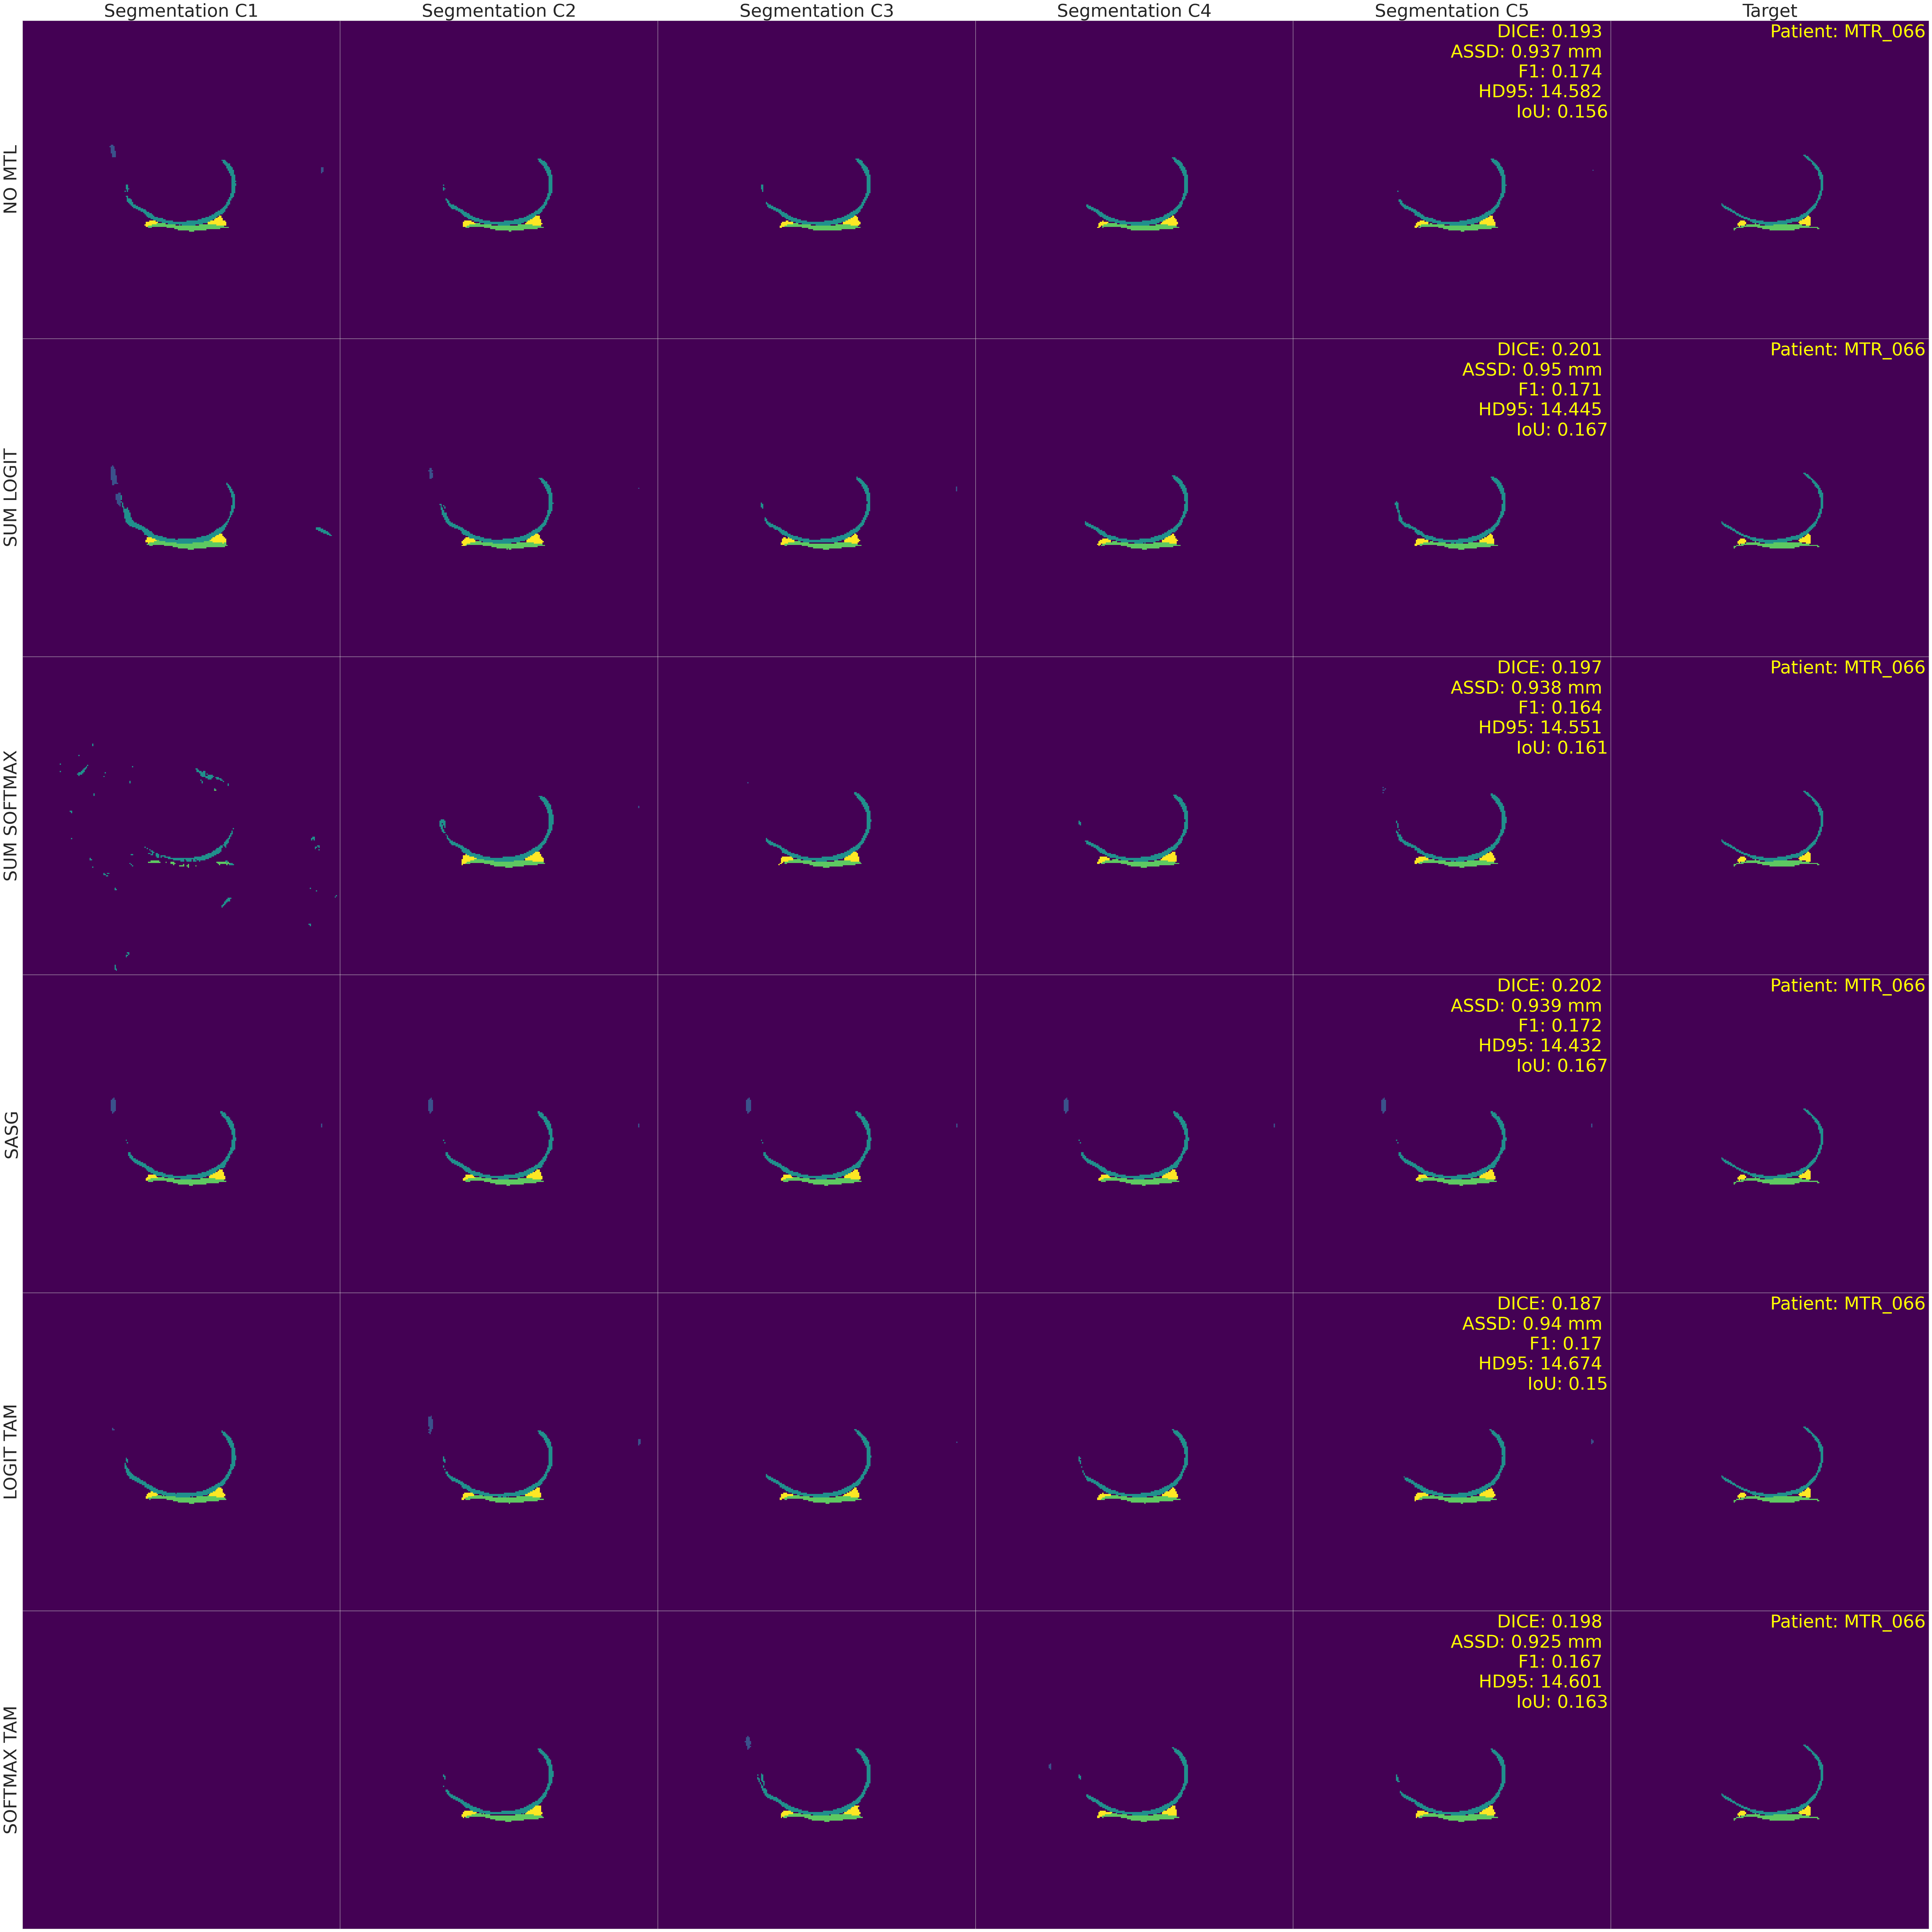

In [369]:
hsize = 10
ticks = [0,1,2,3,4]
wsize = hsize / target_mtlrs_1.shape[2] * target_mtlrs_1.shape[3]
print(segmentation_labels_mtlrs_1[slice,1:][np.newaxis].shape)
dice_score =dice_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_no_mtl[slice,1:,4][np.newaxis])
print(dice_score)
assd_score =float(asd(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_no_mtl[slice,1:,4][np.newaxis]))
f1_score =float(f1_per_class_metric(segmentation_labels_mtlrs_1[slice,1:,][np.newaxis],inter_seg_no_mtl[slice,1:,4][np.newaxis]))
HD95_score =float(hausdorff_distance_95_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_no_mtl[slice,1:,4][np.newaxis]))
IOU_score =float(iou_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_no_mtl[slice,1:,4][np.newaxis]))

inter_seg_no_mtl_plot = torch.argmax(torch.from_numpy(inter_seg_no_mtl),dim=2)
segmentation_labels_mtlrs_1_plot = torch.argmax(torch.from_numpy(segmentation_labels_mtlrs_1),dim=1)

fig, axs = plt.subplots(6, 6, figsize=(6 * wsize, 6 * hsize))
plot_images([inter_seg_no_mtl_plot[slice,0],inter_seg_no_mtl_plot[slice,1],inter_seg_no_mtl_plot[slice,2],inter_seg_no_mtl_plot[slice,3],inter_seg_no_mtl_plot[slice,4],segmentation_labels_mtlrs_1_plot[slice]],titles=["Segmentation C1","Segmentation C2","Segmentation C3","Segmentation C4","Segmentation C5","Target"],axs=axs[0],fontsize =40,cmap=['viridis','viridis','viridis','viridis','viridis','viridis','viridis'],ticks=ticks,text=[None,None,None,None,f'DICE: {round(dice_score,3)} \n ASSD: {round(assd_score,3)} mm \n F1: {round(f1_score,3)} \n HD95: {round(HD95_score,3)} \n IoU: {round(IOU_score,3)}',f'Patient: {Patient_id}'])
axs[0][0].set_ylabel("NO MTL", fontsize=40)
dice_score =dice_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit[slice,1:,4][np.newaxis])
assd_score =float(asd(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit[slice,1:,4][np.newaxis]))
f1_score =float(f1_per_class_metric(segmentation_labels_mtlrs_1[slice,1:,][np.newaxis],inter_seg_logit[slice,1:,4][np.newaxis]))
HD95_score =float(hausdorff_distance_95_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit[slice,1:,4][np.newaxis]))
IOU_score =float(iou_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit[slice,1:,4][np.newaxis]))

inter_seg_logit_plot = torch.argmax(torch.from_numpy(inter_seg_logit),dim=2)
plot_images([inter_seg_logit_plot[slice,0],inter_seg_logit_plot[slice,1],inter_seg_logit_plot[slice,2],inter_seg_logit_plot[slice,3],inter_seg_logit_plot[slice,4],segmentation_labels_mtlrs_1_plot[slice]],axs=axs[1],fontsize =40,cmap=['viridis','viridis','viridis','viridis','viridis','viridis','viridis'],ticks=ticks,text=[None,None,None,None,f'DICE: {round(dice_score,3)} \n ASSD: {round(assd_score,3)} mm \n F1: {round(f1_score,3)} \n HD95: {round(HD95_score,3)} \n IoU: {round(IOU_score,3)}',f'Patient: {Patient_id}'])
axs[1,0].set_ylabel("SUM LOGIT", fontsize=40)
dice_score =dice_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_sum[slice,1:,4][np.newaxis])
assd_score =float(asd(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_sum[slice,1:,4][np.newaxis]))
f1_score =float(f1_per_class_metric(segmentation_labels_mtlrs_1[slice,1:,][np.newaxis],inter_seg_softmax_sum[slice,1:,4][np.newaxis]))
HD95_score =float(hausdorff_distance_95_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_sum[slice,1:,4][np.newaxis]))
IOU_score =float(iou_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_sum[slice,1:,4][np.newaxis]))

inter_seg_softmax_sum_plot = torch.argmax(torch.from_numpy(inter_seg_softmax_sum),dim=2)
plot_images([inter_seg_softmax_sum_plot[slice,0],inter_seg_softmax_sum_plot[slice,1],inter_seg_softmax_sum_plot[slice,2],inter_seg_softmax_sum_plot[slice,3],inter_seg_softmax_sum_plot[slice,4],segmentation_labels_mtlrs_1_plot[slice]],axs=axs[2],fontsize =40,cmap=['viridis','viridis','viridis','viridis','viridis','viridis','viridis'],ticks=ticks,text=[None,None,None,None,f'DICE: {round(dice_score,3)} \n ASSD: {round(assd_score,3)} mm \n F1: {round(f1_score,3)} \n HD95: {round(HD95_score,3)} \n IoU: {round(IOU_score,3)}',f'Patient: {Patient_id}'])
axs[2,0].set_ylabel("SUM SOFTMAX", fontsize=40)
dice_score =dice_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_sasg[slice,1:,4][np.newaxis])
assd_score =float(asd(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_sasg[slice,1:,4][np.newaxis]))
f1_score =float(f1_per_class_metric(segmentation_labels_mtlrs_1[slice,1:,][np.newaxis],inter_seg_sasg[slice,1:,4][np.newaxis]))
HD95_score =float(hausdorff_distance_95_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_sasg[slice,1:,4][np.newaxis]))
IOU_score =float(iou_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_sasg[slice,1:,4][np.newaxis]))

inter_seg_sasg_plot = torch.argmax(torch.from_numpy(inter_seg_sasg),dim=2)
plot_images([inter_seg_sasg_plot[slice,0],inter_seg_sasg_plot[slice,0],inter_seg_sasg_plot[slice,0],inter_seg_sasg_plot[slice,0],inter_seg_sasg_plot[slice,0],segmentation_labels_mtlrs_1_plot[slice]],axs=axs[3],fontsize =40,cmap=['viridis','viridis','viridis','viridis','viridis','viridis','viridis'],ticks=ticks,text=[None,None,None,None,f'DICE: {round(dice_score,3)} \n ASSD: {round(assd_score,3)} mm \n F1: {round(f1_score,3)} \n HD95: {round(HD95_score,3)} \n IoU: {round(IOU_score,3)}',f'Patient: {Patient_id}'])
axs[3,0].set_ylabel("SASG", fontsize=40)
dice_score =dice_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit_tam[slice,1:,4][np.newaxis])
assd_score =float(asd(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit_tam[slice,1:,4][np.newaxis]))
f1_score =float(f1_per_class_metric(segmentation_labels_mtlrs_1[slice,1:,][np.newaxis],inter_seg_logit_tam[slice,1:,4][np.newaxis]))
HD95_score =float(hausdorff_distance_95_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit_tam[slice,1:,4][np.newaxis]))
IOU_score =float(iou_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_logit_tam[slice,1:,4][np.newaxis]))

inter_seg_logit_tam_plot = torch.argmax(torch.from_numpy(inter_seg_logit_tam),dim=2)
plot_images([inter_seg_logit_tam_plot[slice,0],inter_seg_logit_tam_plot[slice,1],inter_seg_logit_tam_plot[slice,2],inter_seg_logit_tam_plot[slice,3],inter_seg_logit_tam_plot[slice,4],segmentation_labels_mtlrs_1_plot[slice]],axs=axs[4],fontsize =40,cmap=['viridis','viridis','viridis','viridis','viridis','viridis','viridis'],ticks=ticks,text=[None,None,None,None,f'DICE: {round(dice_score,3)} \n ASSD: {round(assd_score,3)} mm \n F1: {round(f1_score,3)} \n HD95: {round(HD95_score,3)} \n IoU: {round(IOU_score,3)}',f'Patient: {Patient_id}'])

axs[4,0].set_ylabel("LOGIT TAM", fontsize=40)
dice_score =dice_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_tam[slice,1:,4][np.newaxis])
assd_score =float(asd(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_tam[slice,1:,4][np.newaxis]))
f1_score =float(f1_per_class_metric(segmentation_labels_mtlrs_1[slice,1:,][np.newaxis],inter_seg_softmax_tam[slice,1:,4][np.newaxis]))
HD95_score =float(hausdorff_distance_95_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_tam[slice,1:,4][np.newaxis]))
IOU_score =float(iou_metric(segmentation_labels_mtlrs_1[slice,1:][np.newaxis],inter_seg_softmax_tam[slice,1:,4][np.newaxis]))
inter_seg_softmax_tam_plot = torch.argmax(torch.from_numpy(inter_seg_softmax_tam),dim=2)
plot_images([inter_seg_softmax_tam_plot[slice,0],inter_seg_softmax_tam_plot[slice,1],inter_seg_softmax_tam_plot[slice,2],inter_seg_softmax_tam_plot[slice,3],inter_seg_softmax_tam_plot[slice,4],segmentation_labels_mtlrs_1_plot[slice]],axs=axs[5],fontsize =40,cmap=['viridis','viridis','viridis','viridis','viridis','viridis','viridis'],ticks=ticks,text=[None,None,None,None,f'DICE: {round(dice_score,3)} \n ASSD: {round(assd_score,3)} mm \n F1: {round(f1_score,3)} \n HD95: {round(HD95_score,3)} \n IoU: {round(IOU_score,3)}',f'Patient: {Patient_id}'])
axs[5,0].set_ylabel("SOFTMAX TAM", fontsize=40)
plt.tight_layout(pad=0)
plt.savefig(f"/scratch/tmpaquaij/Figures/IP/Intermediate_segmentation_inter_UQ_{Patient_id}_slice:{str(slice)}.png")

plt.show()

In [331]:
#Quantitative Analysis of Uncertainty
#mean and std soft tissue uncertainty of std in deep ensemlbe
echo=0
index = ['NO MTL',"LOGIT SUM","SOFTMAX SUM","SASG","LOGIT TAM","SOFTMAX TAM"]
dataframe = pd.DataFrame(index=index)
for cascade in range(5):
    std_no_mtl_soft = std_no_mtl*np.expand_dims(np.sum(segmentation_labels_mtlrs_1[:,1:],axis=1),axis=[1,2])
    mean_std_no_mtl_soft = round(np.mean(std_no_mtl_soft[:,cascade,echo]),5)
    std_logit_soft = std_logit*np.expand_dims(np.sum(segmentation_labels_mtlrs_1[:,1:],axis=1),axis=[1,2])
    mean_std_logit_soft = round(np.mean(std_logit_soft[:,cascade,echo]),5)
    std_softmax_sum_soft = std_softmax_sum*np.expand_dims(np.sum(segmentation_labels_mtlrs_1[:,1:],axis=1),axis=[1,2])
    mean_std_softmax_sum_soft = round(np.mean(std_softmax_sum_soft[:,cascade,echo]),5)
    std_sasg_soft = std_sasg*np.expand_dims(np.sum(segmentation_labels_mtlrs_1[:,1:],axis=1),axis=[1,2])
    mean_std_sasg_soft = round(np.mean(std_sasg_soft[:,cascade,echo]),5)
    std_logit_tam_soft = std_logit_tam*np.expand_dims(np.sum(segmentation_labels_mtlrs_1[:,1:],axis=1),axis=[1,2])
    mean_std_logit_tam_soft = round(np.mean(std_logit_tam_soft[:,cascade,echo]),5)
    std_softmax_tam_soft = std_softmax_tam*np.expand_dims(np.sum(segmentation_labels_mtlrs_1[:,1:],axis=1),axis=[1,2])
    mean_std_softmax_tam_soft = round(np.mean(std_softmax_tam_soft[:,cascade,echo]),5)
    dataframe[f'Cascade: {cascade}']= [mean_std_no_mtl_soft,mean_std_logit_soft,mean_std_softmax_sum_soft,mean_std_sasg_soft,mean_std_logit_tam_soft,mean_std_softmax_tam_soft]

# with pd.ExcelWriter("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/results_UQ_soft_tissue.xlsx") as writer:
#     dataframe.to_excel(writer,sheet_name=f'{Patient_id}')


[atommic W 2024-06-05 11:42:22 atommic_logging:336] /home/tmpaquaij/tmp/ipykernel_57122/60833968.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
      plt.tight_layout(pad=0)
    


6
go
go
go
go
go
go


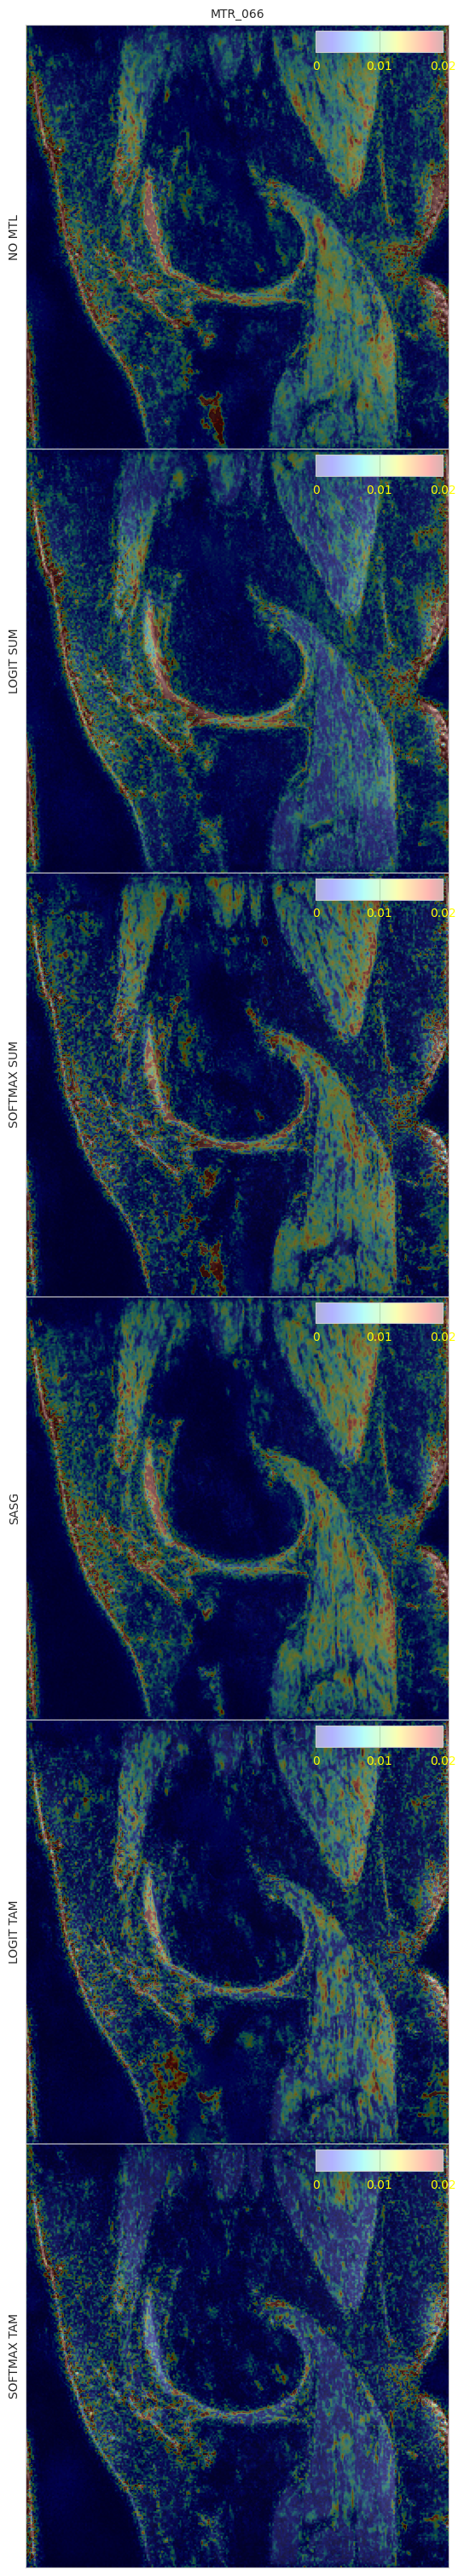

In [339]:

hsize = 5
ticks_overlay= [0,0.01,0.02]
fontsize=10
wsize = hsize / target_mtlrs_1.shape[2] * target_mtlrs_1.shape[3]
fig, axs = plt.subplots(6, 1, figsize=(1 * wsize, 6 * hsize))
plot_images(images=[mean_no_mtl[slice,4,echo],mean_logit[slice,4,echo],mean_softmax_sum[slice,4,echo],mean_sasg[slice,4,echo],mean_logit_tam[slice,4,echo],mean_softmax_tam[slice,4,echo]],titles=[f"{Patient_id}",None,None,None,None,None],axs=axs,overlay=[std_no_mtl[slice,4,echo],std_logit[slice,4,echo],std_softmax_sum[slice,4,echo],std_sasg[slice,4,echo],std_logit_tam[slice,4,echo],std_softmax_tam[slice,4,echo]],show_cbar_overlay=[True,True,True,True,True,True],fontsize =fontsize,ticks_overlay=ticks_overlay,opacity=0.3)
axs[0].set_ylabel("NO MTL", fontsize=fontsize)
axs[1].set_ylabel("LOGIT SUM", fontsize=fontsize)
axs[2].set_ylabel("SOFTMAX SUM", fontsize=fontsize)
axs[3].set_ylabel("SASG", fontsize=fontsize)
axs[4].set_ylabel("LOGIT TAM", fontsize=fontsize)
axs[5].set_ylabel("SOFTMAX TAM", fontsize=fontsize)
plt.tight_layout(pad=0)
plt.savefig("/scratch/tmpaquaij/Figures/IP/Intermediate_"+intermidiate_form+f"_DeepEnsemble_UQ_{Patient_id}_Echo:{str(echo)}_slice:{str(slice)}_last_cascade.png")